Enter minimum points threshold as neighbors: 3
Enter epsilon radius: 0.8
0.2845701839961885
0.6460684876669074


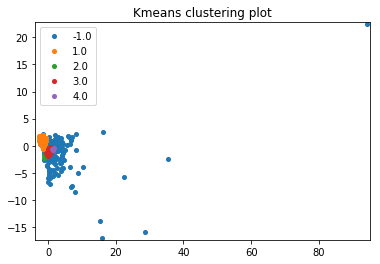

In [39]:
#Density based algorithm. DBSCAN 
import numpy as np
import sys
from scipy.spatial import distance
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform


np.set_printoptions(suppress=True) #prevent numpy exponential 

def read_data(file):
    gene_data = open(file)
    gene_seq = gene_data.readlines()
    all_genes_list = []
    for line in gene_seq:
        gene = line.strip().split("\t")
        all_genes_list.append(gene)
    return np.asarray(all_genes_list, dtype = float)

def DBSCAN(data, min_points, eps_value):
    cluster_id = 0
    visited = dict()
    for i in range(0,len(data)):
        visited[i] = "Unvisited"
        
    for g in range(0,len(data)):
        if (visited[g] == "Unvisited"):
            #visited[g] = "Visited"
            neighbor_points = regionQuery(data, g, eps_value)
            if (len(neighbor_points) < min_points):
                visited[g] = "Noise"
            else:
                cluster_id += 1
                expand_cluster(data, g, neighbor_points,eps_value, min_points, visited, cluster_id)
        
    return visited
        
def regionQuery(data, g, eps_value):
    neighbor_pts = []
    for ng in range(0, len(data)):
        dist = distance.euclidean(data[g], data[ng])
        if(dist <= eps_value):
            neighbor_pts.append(ng)
    return neighbor_pts

def expand_cluster(data, g, neighbor_points,eps_value, min_points, visited, cluster_id):
    visited[g] = cluster_id
    i = 0
    while(i < len(neighbor_points)):
        gene_id = neighbor_points[i]
        if visited[gene_id] == "Noise":
            visited[gene_id] = cluster_id
            
        if(visited[gene_id] == "Unvisited"):
            visited[gene_id] = cluster_id
            extended_neighbors = regionQuery(data, gene_id, eps_value)
            if(len(extended_neighbors) >= min_points):
                neighbor_points = neighbor_points+extended_neighbors  #check 
        i += 1
                
def compute_similarity_terms(gene_data, cluster_ids):
    m11 = 0
    m01 = 0
    m10 = 0
    m00 = 0
    final_clusters = np.zeros(gene_data.shape[0])
    for g1 in range(0,gene_data.shape[0]):
        g1_ground_truth = gene_data[g1][1]
        g1_cluster_id = cluster_ids[g1]
        if(g1_cluster_id == "Noise"):
            g1_cluster_id = -1
            cluster_ids[g1] = -1
        final_clusters[g1] = g1_cluster_id
        #print(g1_ground_truth, " : ", g1_cluster_id)
        for g2 in range(0, gene_data.shape[0]):
            g2_ground_truth = gene_data[g2][1]
            g2_cluster_id = cluster_ids[g2]
            if(g2_cluster_id == "Noise"):
                g2_cluster_id = -1 
                cluster_ids[g2] = -1
            if(g1_ground_truth == g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m11 += 1
            elif(g1_ground_truth == g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m10 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m01 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m00 += 1
    return m11, m01, m10, m00, final_clusters

def plot_PCA(gene_features,cluster_ids):
    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(gene_features)

    # Appending disease column to dimensionally reduced data
    cluster_ids = cluster_ids.reshape(gene_features.shape[0],1)
    newData = np.hstack((data_reduced,cluster_ids))

    #Plotting the 2D data
    newDf = pd.DataFrame(data = newData)
    groups = newDf.groupby(newDf.columns[newData.shape[1]-1])

    fig, ax = plt.subplots()
    plt.title('Kmeans clustering plot')
    ax.margins(0.01)
    for name, group in groups:
        ax.plot(group[0], group[1], marker='o', linestyle='', ms=4, label=name)
    ax.legend(numpoints=1, loc='best')

    plt.show()
    
gene_data = read_data("iyer.txt")
gene_features = gene_data[:,2:]
min_points = int(input("Enter minimum points threshold as neighbors: "))
eps_value = float(input("Enter epsilon radius: "))
clusters = DBSCAN(gene_features, min_points, eps_value)
m11, m01, m10, m00, final_clusters = compute_similarity_terms(gene_data, clusters)
jacard_coef = float(m11)/float(m11+m10+m01)
print(jacard_coef)

rand_index = float(m11+m00)/float(m11+m10+m01+m00)
print(rand_index)

#Plot PCA for gene_features data set
plot_PCA(gene_features,final_clusters)